Below is the code for my project. To start, I had to do some preprocessing to create the graph. I removed any NAs then made the node feature vectors and processed the labels. I then manually set edges between nodes with the same MRN (patient identifier) and then as discussed in the paper I included random edges between patients of similar profiles (same gender, within 1 year of age, presence of condition). Note that I set edges both way so it would be an undirected graph. The weight of the graph also utilized an exponential decay function to place higher weight on ECGs taken closer together. The weight for the random edges were also multiplied by 0.4 to denote a lower association. 


NOTE: Below it shows just one run with random seed. The other seeds are commented. Also, the results will not be good as I have included a Toy Dataset. Professor Ying suggested I do this as my dataset is HIPAA protected. I have included the true output when I ran the code with the actual dataset.

In [ ]:
import pandas as pd
import torch
from datetime import datetime
from torch_geometric.data import Data
import numpy as np  
from itertools import combinations
from torch_geometric.utils import to_undirected
import numpy as np
from tqdm import tqdm
import random
import networkx as nx
import matplotlib.pyplot as plt
# Load data
random.seed(42)
# I used these other seeds
# random.seed(140)
# random.seed(8)
df = pd.read_csv('Toy_Dataset.csv')
print(df.shape)
columns_to_check = ['QRS_Duration', 'QT_Interval', 'QTc_Interval','P_Axis', 'QRS_Axis', 
                          'T_Axis', 'PatientSex_ECGData', 'PatientAge_ECGData','predictions_EF', 'Under40']

# Drop rows where any of the specified columns have NaN values
df = df.dropna(subset=columns_to_check)
df = df.reset_index(drop=True)
print(df.shape)
# Convert 'fileID' date extraction
df['date'] = pd.to_datetime(df['fileID'].str.extract(r'(\d{8})')[0], format='%Y%m%d')

# Extract age from 'PatientAge_ECGData' and convert to integer
df['PatientAge_years'] = df['PatientAge_ECGData'].str.extract(r'(\d+)').astype(int)
# Node features

features = torch.tensor(df[['QRS_Duration', 'QT_Interval', 'QTc_Interval', 'P_Axis', 'QRS_Axis', 
                          'T_Axis', 'predictions_EF']].values, dtype=torch.float)
# Node labels
labels = torch.tensor(df['Under40'].values, dtype=torch.long)


edge_index = []
edge_attr = []

# Set the decay parameter lambda
lambda_decay = 0.01  # This value might need tuning based on your specific dataset

# Create edges based on MRN and compute the difference in days with exponential decay
mrn_groups = df.groupby('MRN')
for name, group in tqdm(mrn_groups, desc="MRN Groups"):
    for (i, j) in combinations(group.index, 2):
        days_diff = abs((df.loc[i, 'date'] - df.loc[j, 'date']).days)
        weight = np.exp(-lambda_decay * days_diff)
        edge_index.append([i, j])
        edge_index.append([j, i])
        edge_attr.append(weight)
        edge_attr.append(weight)

print("Done with MRN based edges")

max_edges = 1000  # Set the maximum number of random edges you want to add- this parameter should be changed when the dataset is smaller
count_edges = 0
# Random edges with exponential decay based on day differences
existing_pairs = set()

lambda_decay = 0.01  # Adjust as needed

while count_edges < max_edges:
    # Randomly select two different indices
    i, j = random.sample(range(len(df)), 2)

    # Ensure i is always less than j to maintain order and avoid duplicates like (j, i)
    if i > j:
        i, j = j, i

    # Create a tuple of the pair
    edge_pair = (i, j)

    # Check if the edge already exists
    if edge_pair not in existing_pairs:
        # Check if they meet the criteria
        if df.loc[i, 'MRN'] != df.loc[j, 'MRN'] and \
           abs(df.loc[i, 'PatientAge_years'] - df.loc[j, 'PatientAge_years']) <= 1 and \
           df.loc[i, 'PatientSex_ECGData'] == df.loc[j, 'PatientSex_ECGData'] and \
           df.loc[i, 'Under40'] == df.loc[j, 'Under40']:
            days_diff = abs((df.loc[i, 'date'] - df.loc[j, 'date']).days)
            weight = np.exp(-lambda_decay * days_diff * 0.4)  # Adjust weight with exponential decay
            edge_index.append([i, j])
            edge_index.append([j, i])
            edge_attr.append(weight)
            edge_attr.append(weight)
            existing_pairs.add(edge_pair)
            count_edges += 1  # Increment the count of edges

            # Provide progress update
            if count_edges % 1000 == 0:
                print(f"Added {count_edges} edges")

#Convert lists to tensors and make the graph undirected



(110836, 24)
(93068, 24)


MRN Groups: 100%|██████████| 10078/10078 [00:38<00:00, 264.85it/s]


Done with MRN based edges
Added 1000 edges


Let's get a quick idea of our data. Plotting the histogram of node degrees. Also printing shapes of data before creating the Data object.

torch.Size([2, 1880052])
torch.Size([1880052])
Data(x=[93068, 1], edge_index=[2, 1880052], edge_attr=[1880052], y=[93068])


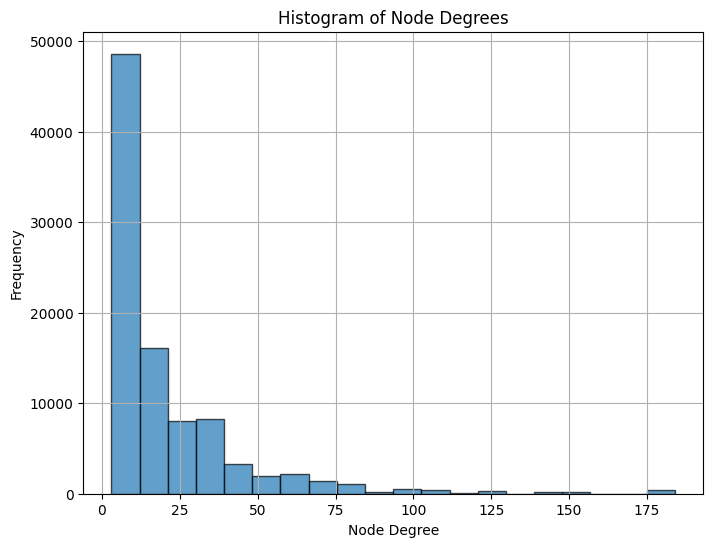

In [2]:
from torch_geometric.utils import degree


edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t()
print(edge_index_tensor.shape)
edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float)
print(edge_attr_tensor.shape)
data = Data(x=features, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor, y=labels)
print(data)

num_nodes = edge_index_tensor.max().item() + 1  # Total number of nodes
degrees = degree(edge_index_tensor[0], num_nodes=num_nodes).cpu().numpy()

# Plot histogram of node degrees
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Node Degree')
plt.ylabel('Frequency')
plt.title('Histogram of Node Degrees')
plt.grid(True)
plt.show()


Now we will define the model architecture for a GCN.

In [3]:

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 36)
        self.conv2 = GCNConv(36, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

Now we set the training and testing split.

In [4]:

num_nodes = data.y.size(0)
perm = torch.randperm(num_nodes)
train_size = int(num_nodes * 0.8)  # 80% for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True
test_mask[perm[train_size:]] = True

data.train_mask = train_mask
data.test_mask = test_mask

Time to train the model!

Epoch 10, Loss: 0.5410557389259338
Epoch 20, Loss: 0.3804834187030792
Epoch 30, Loss: 0.27670571208000183
Epoch 40, Loss: 0.22008711099624634
Epoch 50, Loss: 0.21052244305610657
Epoch 60, Loss: 0.21381910145282745
Epoch 70, Loss: 0.21138842403888702
Epoch 80, Loss: 0.21139153838157654
Epoch 90, Loss: 0.2113710343837738
Epoch 100, Loss: 0.2095358967781067
Epoch 110, Loss: 0.20948049426078796
Epoch 120, Loss: 0.20903514325618744
Epoch 130, Loss: 0.20914508402347565
Epoch 140, Loss: 0.2069457620382309
Epoch 150, Loss: 0.2069915533065796
Epoch 160, Loss: 0.20753520727157593
Epoch 170, Loss: 0.20712052285671234
Epoch 180, Loss: 0.2062559425830841
Epoch 190, Loss: 0.20580530166625977
Epoch 200, Loss: 0.20638473331928253


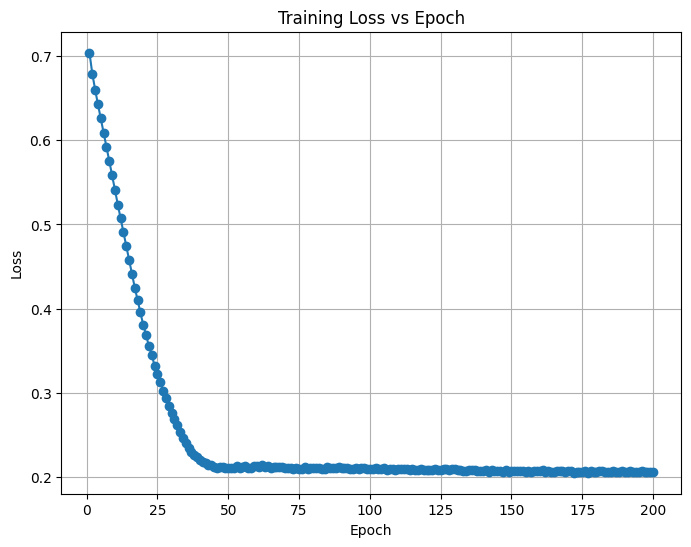

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=features.shape[1], num_classes=2)  # Adjust num_classes accordingly
model = model.to(device)
data = data.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
def train_gcn(model, data, optimizer, epochs):
    model.train()
    losses = []  # Store loss for each epoch
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        # Print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

    # Plot loss vs epoch
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epoch')
    plt.grid(True)
    plt.show()

train_gcn(model, data, optimizer, 200)

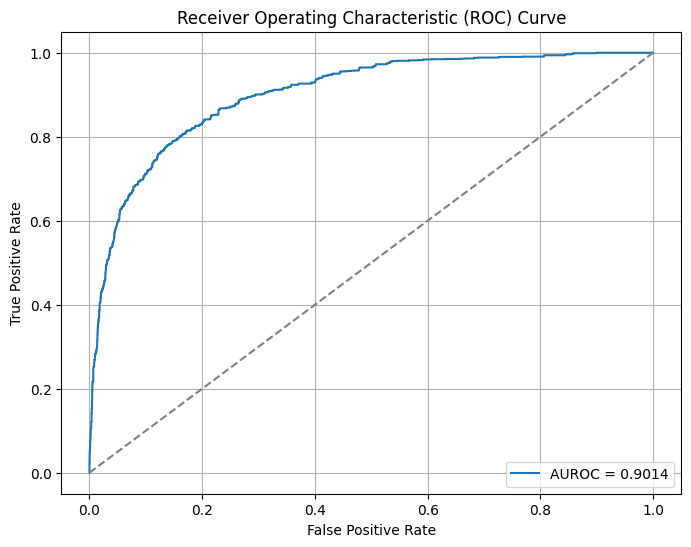

Test AUROC: 0.9014


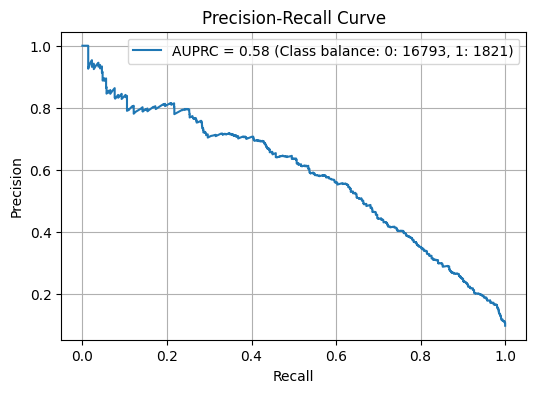

Test AUPRC: 0.5850


In [6]:
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
def calculate_auroc(model, data):
    model.eval()
    with torch.no_grad():
        # Get the model outputs
        out = model(data.x, data.edge_index)
        # Apply softmax to get probabilities
        # Assuming the second column corresponds to the positive class probabilities
        y_probs = out.softmax(dim=1)[:, 1]
        # Get the actual labels and predicted probabilities for the test mask
        y_true = data.y[data.test_mask].cpu().numpy()
        y_scores = y_probs[data.test_mask].cpu().numpy()
        
        # Calculate AUROC
        auroc = roc_auc_score(y_true, y_scores)

        # Compute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        # Plot the ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random chance
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        return auroc
# Complete your training loop first

def plot_auprc(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        y_probs = out.softmax(dim=1)[:, 1]

        y_true = data.y[data.test_mask].cpu().numpy()
        y_scores = y_probs[data.test_mask].cpu().numpy()

        # Compute class balance
        unique, counts = np.unique(y_true, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        balance_str = ', '.join([f'{cls}: {cnt}' for cls, cnt in class_distribution.items()])

        # Compute AUPRC
        ap = average_precision_score(y_true, y_scores)
        precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

        # Plot Precision-Recall curve with class balance in the label
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, label=f'AUPRC = {ap:.2f} (Class balance: {balance_str})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return ap

# After training, calculate and print AUROC for the test set
auroc = calculate_auroc(model, data)
print(f'Test AUROC: {auroc:.4f}')
ap = plot_auprc(model, data)
print(f'Test AUPRC: {ap:.4f}')

For context, I have provided the prevalence of the condition as well in the statistics above, which is about a 9.8% prevalence (also in paper). Now, let's try optimizing our graph neural network paramaters (LR, optimizer). I am also trying a GAT network. 


In [7]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 8, heads=8, dropout=0.6)  # 8 attention heads
        self.conv2 = GATConv(8 * 8, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

def train_gcn_optimizing(model, data, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()


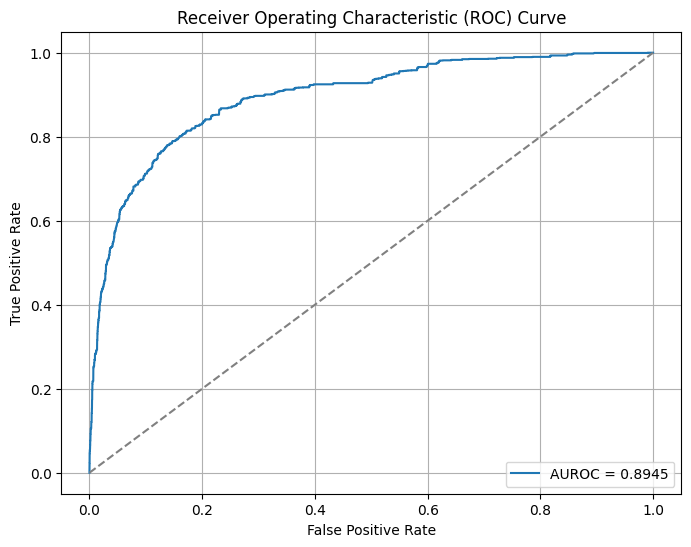

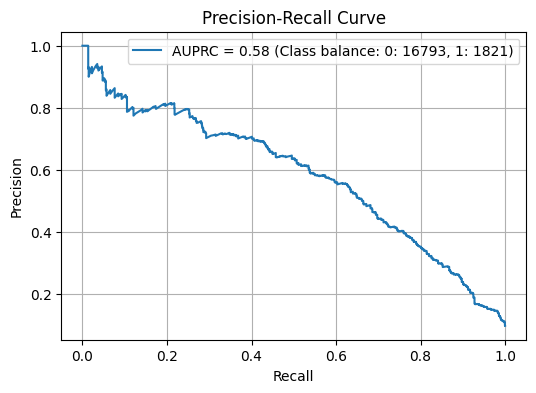

Model: GCN, Optimizer: Adam, Learning Rate: 0.001, Test AUROC: 0.8945, Test AUPRC: 0.5822


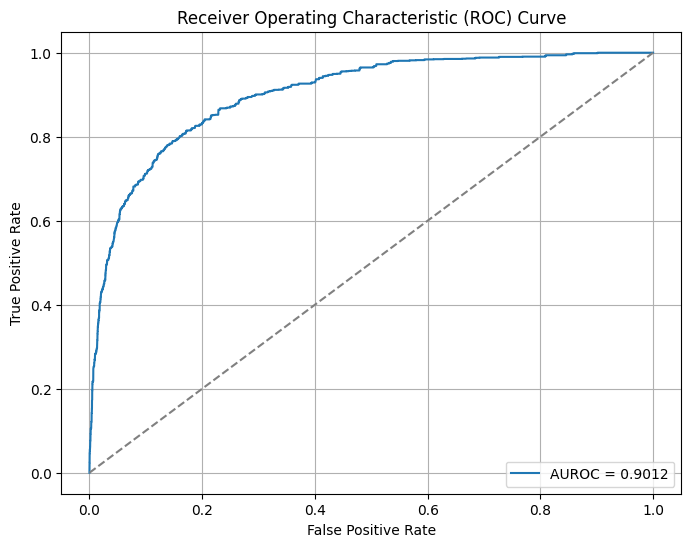

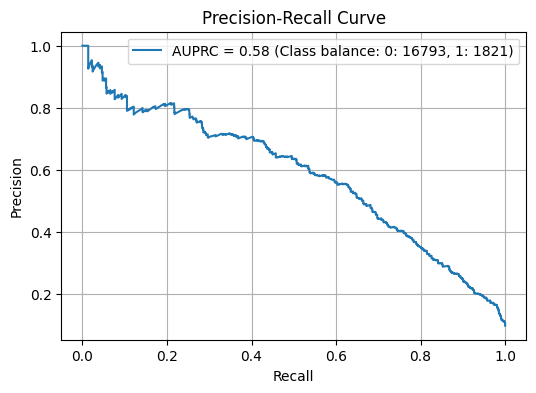

Model: GCN, Optimizer: Adam, Learning Rate: 0.01, Test AUROC: 0.9012, Test AUPRC: 0.5845


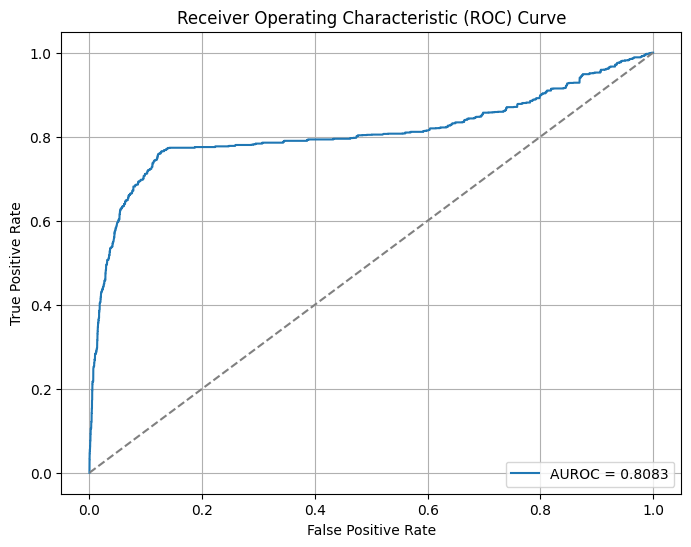

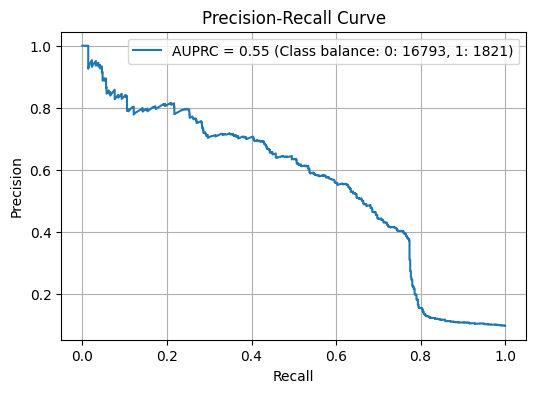

Model: GCN, Optimizer: Adagrad, Learning Rate: 0.001, Test AUROC: 0.8083, Test AUPRC: 0.5544


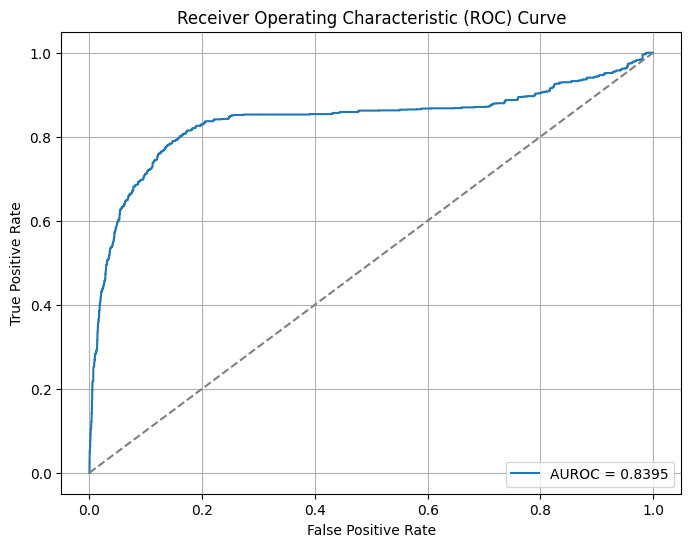

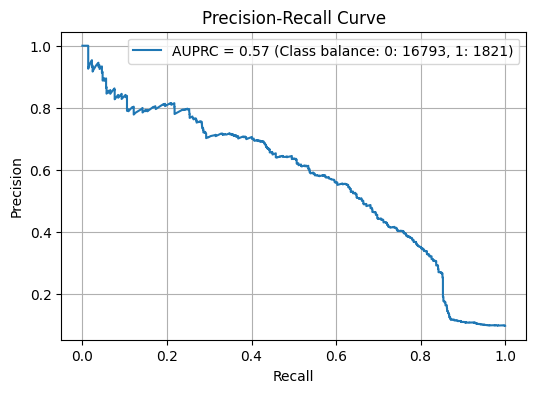

Model: GCN, Optimizer: Adagrad, Learning Rate: 0.01, Test AUROC: 0.8395, Test AUPRC: 0.5690


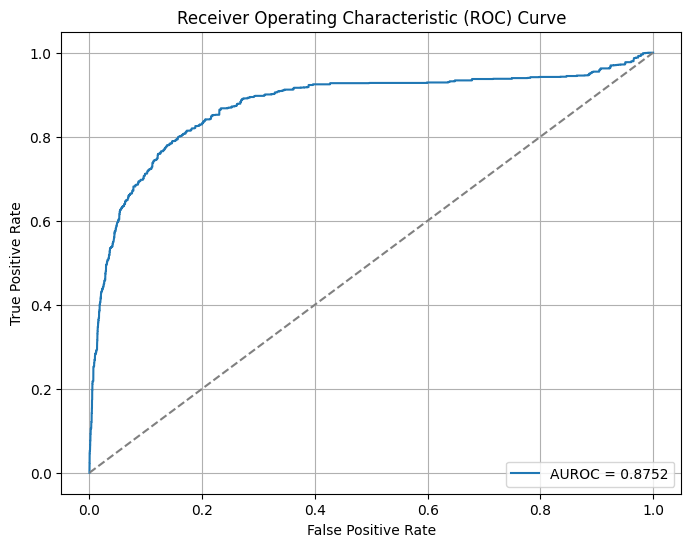

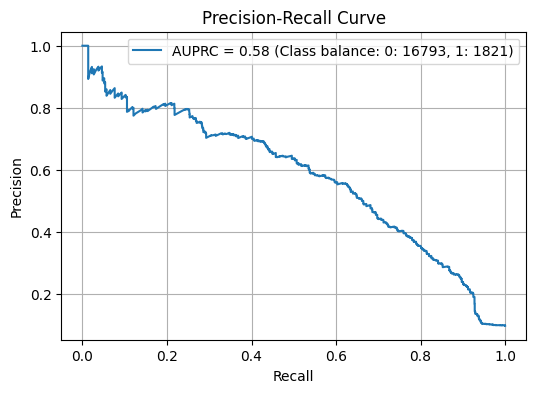

Model: GCN, Optimizer: NAdam, Learning Rate: 0.001, Test AUROC: 0.8752, Test AUPRC: 0.5790


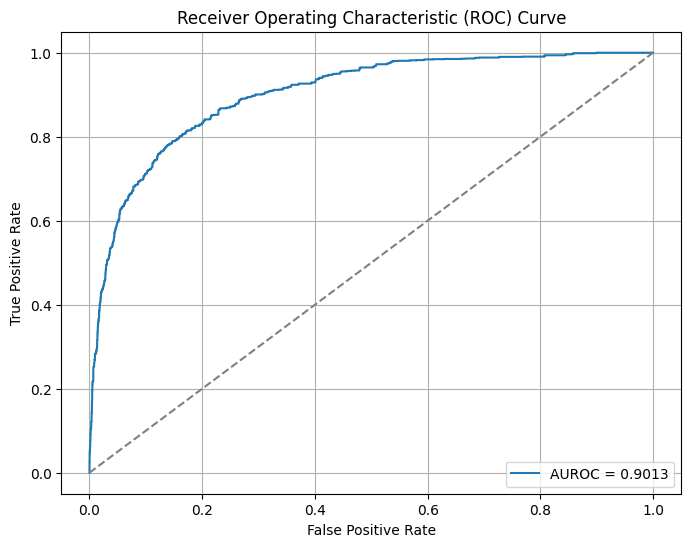

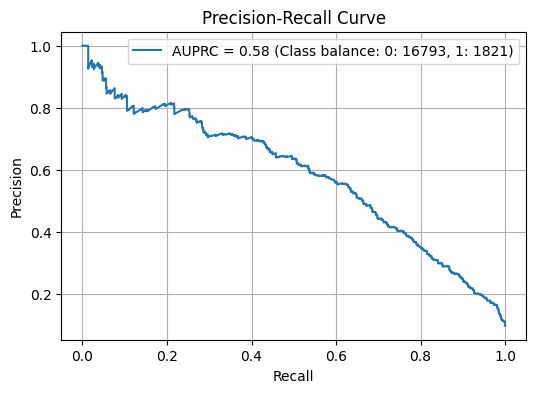

Model: GCN, Optimizer: NAdam, Learning Rate: 0.01, Test AUROC: 0.9013, Test AUPRC: 0.5847


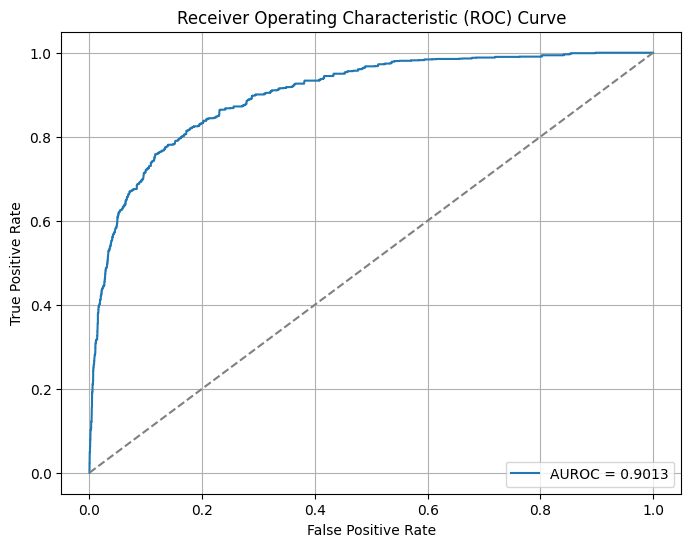

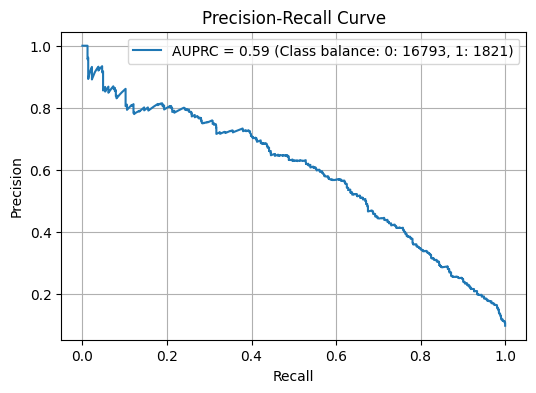

Model: GAT, Optimizer: Adam, Learning Rate: 0.001, Test AUROC: 0.9013, Test AUPRC: 0.5880


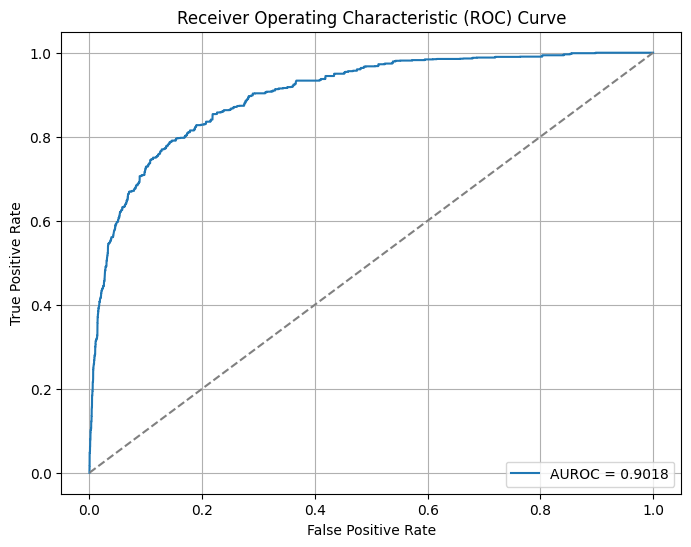

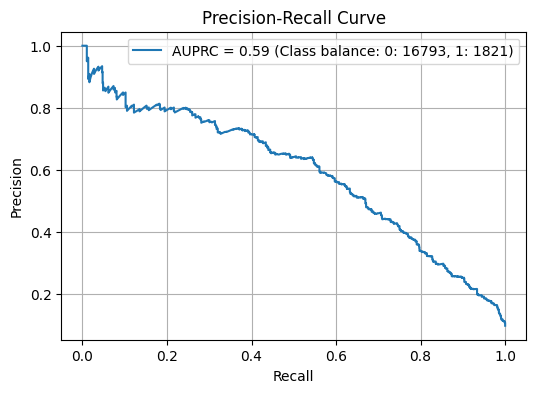

Model: GAT, Optimizer: Adam, Learning Rate: 0.01, Test AUROC: 0.9018, Test AUPRC: 0.5896


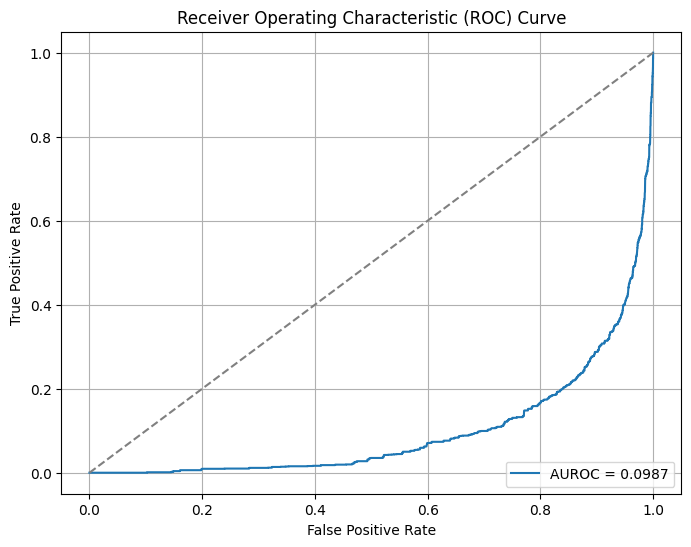

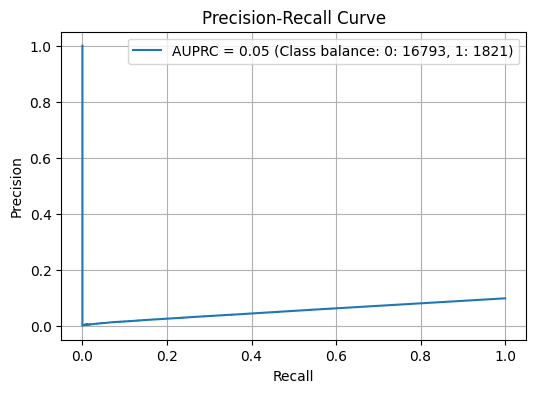

Model: GAT, Optimizer: Adagrad, Learning Rate: 0.001, Test AUROC: 0.0987, Test AUPRC: 0.0527


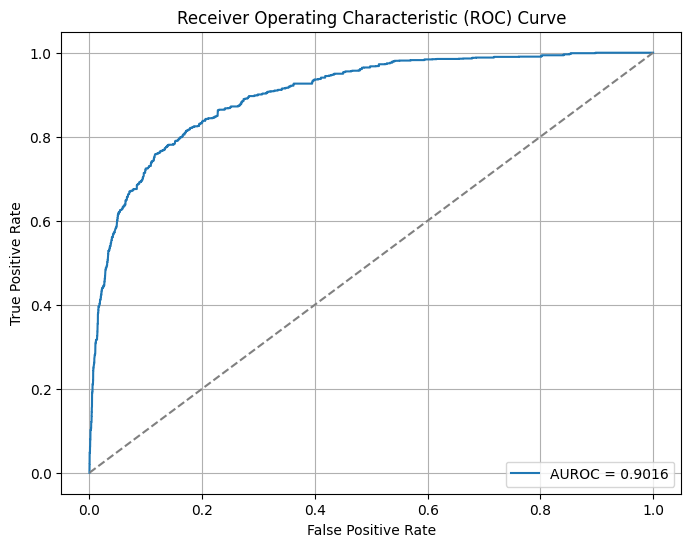

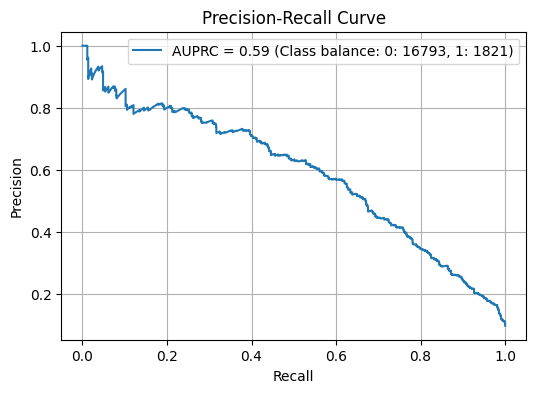

Model: GAT, Optimizer: Adagrad, Learning Rate: 0.01, Test AUROC: 0.9016, Test AUPRC: 0.5884


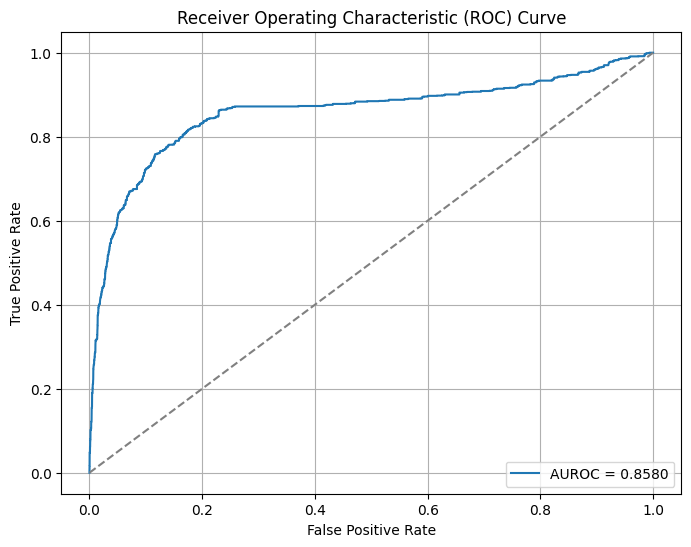

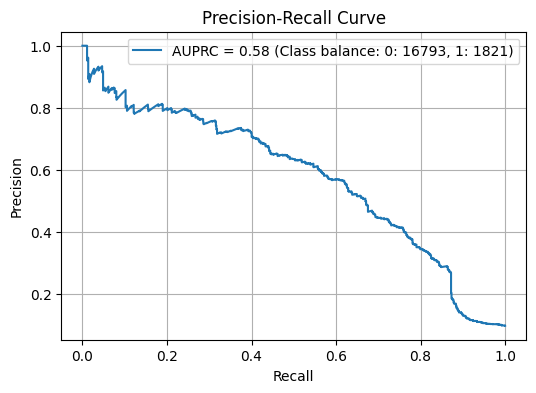

Model: GAT, Optimizer: NAdam, Learning Rate: 0.001, Test AUROC: 0.8580, Test AUPRC: 0.5775


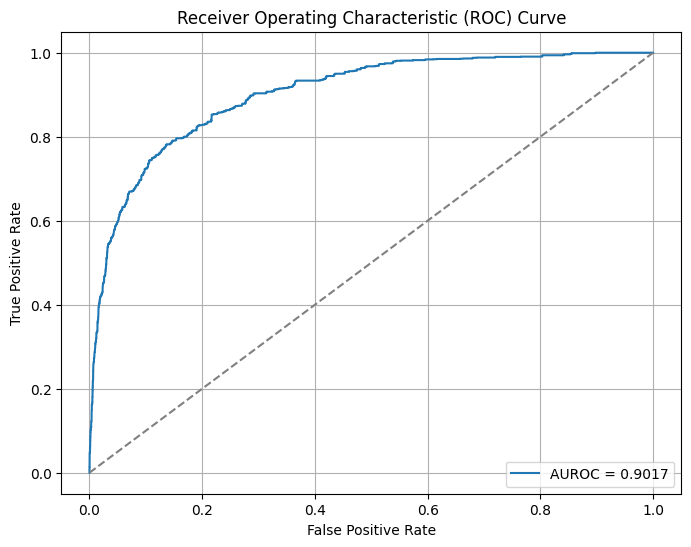

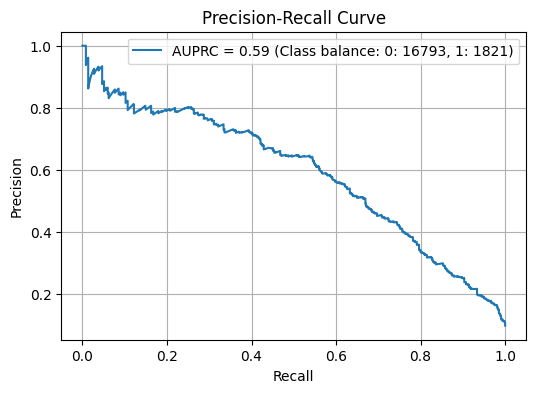

Model: GAT, Optimizer: NAdam, Learning Rate: 0.01, Test AUROC: 0.9017, Test AUPRC: 0.5899


In [8]:
from torch.optim import Adam, SGD, Adagrad, NAdam
def initialize_model(model_type, num_features, num_classes):
    if model_type == "GCN":
        return GCN(num_features, num_classes)
    elif model_type == "GAT":
        return GAT(num_features, num_classes)

models = ["GCN","GAT"]
optimizers = [Adam, Adagrad, NAdam]
learning_rates = [0.001, 0.01]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)  # Assuming 'data' is preloaded and includes train_mask and test_mask

for model_name in models:
    for opt in optimizers:
        for lr in learning_rates:
            model = initialize_model(model_name, num_features=features.shape[1], num_classes=2).to(device)
            optimizer = opt(model.parameters(), lr=lr)
            train_gcn_optimizing(model, data, optimizer, 200)
            auroc = calculate_auroc(model, data)
            ap = plot_auprc(model, data)
            print(f'Model: {model_name}, Optimizer: {opt.__name__}, Learning Rate: {lr}, Test AUROC: {auroc:.4f}, Test AUPRC: {ap:.4f}')

Now I will show the accuracy of the baseline, which is purely based on the CNN probabilities.

No duplicates found.
AUROC: 0.8841454870126569
AUPRC: 0.5403918145395936


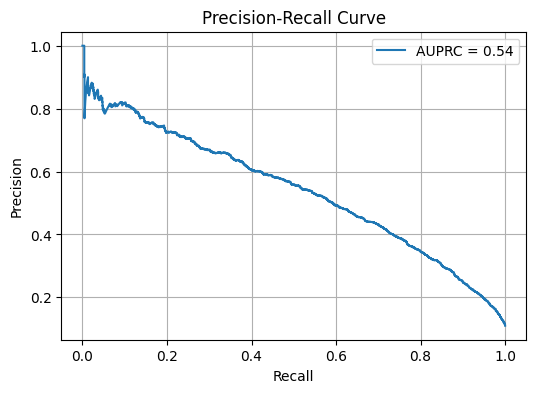

In [ ]:

test_node_features = data.x[data.test_mask]

# If you need this as a NumPy array
test_node_features_array = test_node_features.cpu().numpy()
test_features_df = pd.DataFrame(test_node_features_array, columns=['QRS_Duration', 'QT_Interval', 'QTc_Interval', 'P_Axis', 'QRS_Axis', 
                          'T_Axis', 'predictions_EF'])

df_for_matching = pd.read_csv('Toy_Dataset.csv')

matches = df_for_matching.merge(test_features_df, how='inner', left_index=True, right_index=True, indicator=False)

if matches.duplicated().any():
    print("There are duplicates in the matched rows.")
else:
    print("No duplicates found.")
y_true = matches['Under40'].values
y_scores = matches['predictions_EF_x'].values  



# Calculate AUROC
auroc = roc_auc_score(y_true, y_scores)
print("AUROC:", auroc)


# Calculate AUPRC and plot Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
auprc = average_precision_score(y_true, y_scores)
print("AUPRC:", auprc)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='AUPRC = {:.2f}'.format(auprc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

